In [45]:
import joblib
import numpy as np
import gensim
import tarfile
import boto3
import io
from sagemaker import get_execution_role
import pandas as pd

In [112]:
w2v = gensim.models.Word2Vec.load('word2vec-model.bin')

In [111]:
def term_rankings(H,terms):
    term_rankings = []
    for topic_index in range(H.shape[0]):
        top_indices = np.argsort(H[topic_index,:])[::-1]
        term_ranking = [terms[i] for i in top_indices[:20]]
        term_rankings.append(term_ranking)
    return term_rankings

def similarity( w2v, ranking_i, ranking_j ):
    sim = 0.0
    pairs = 0
    for term_i in ranking_i:
        for term_j in ranking_j:
            try:
                sim += w2v.wv.similarity(term_i, term_j)
                pairs += 1
            except:
                pass
    if pairs == 0:
        return 0.0
    return sim/pairs

def tc_w2v(term_rankings,w2v):
    topic_scores = []
    overall = 0
    for index, topic in enumerate(term_rankings):
        score = similarity(w2v,topic,topic)
        topic_scores.append(score)
        overall += score
    overall /= len(term_rankings)
    return overall

def run_coherence(H,terms,w2v):
    rankings = term_rankings(H,terms)
    coherence = tc_w2v(rankings,w2v)
    return coherence

### Pull down S3 data

#### Models

In [34]:
ole = get_execution_role()
connection = boto3.client('s3')
contents = connection.list_objects(Bucket='ascsagemaker',
                                  Prefix="JMP_congressional_nmf/models")['Contents']

tarballs = [f['Key'] for f in contents if f['Key'].endswith('.tar.gz')]

In [102]:
object_ = connection.get_object(Bucket='ascsagemaker',Key=tarballs[2])['Body'].read()
tar = tarfile.open(fileobj=io.BytesIO(object_))
models = []
for member in tar.getmembers():
    model = joblib.load(tar.extractfile(member=tar.getmember(member.name)))
    model['model'] = member.name
    models.append(model)

#### dtm

In [76]:
dtm = connection.get_object(Bucket='ascsagemaker',
                                  Key="JMP_congressional_nmf/dtms/102.pkl")['Body'].read()

dtm = joblib.load(io.BytesIO(dtm))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator TfidfTransformer from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator TfidfVectorizer from version 0.24.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [113]:
model_coherence = []
for model in models:
    H = model['H']
    k = int(model['model'].split('_')[-1].split('.')[0])
    vocab = dtm['vocab']
    coherence = run_coherence(H,vocab,w2v)
    model_coherence.append({"k":k,'tc-w2v':coherence})

<AxesSubplot:xlabel='k'>

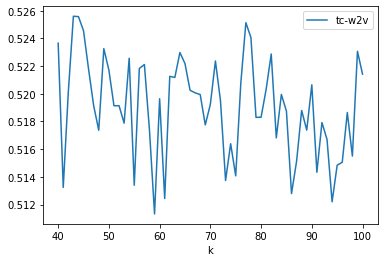

In [115]:
pd.DataFrame(model_coherence).sort_values('k').plot.line(x='k',y='tc-w2v')